### Topic Modeling with Gensim and Mallet
1. create generic LDA model, compute Perplexity and Coherence Score to measure model performance
2. create TfidfModel LDA model, compute Perplexity and Coherence Score to measure model performance
3. create mallet LDA model, compute Perplexity and Coherence Score to measure model performance
4. find the optimal number of topics for LDA

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import os.path

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/Users/emmatoo/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
df = pd.read_csv('processed.csv',index_col=False)
df.head(3)

,Unnamed: 0,id,num_comments,score,subreddit,upvote_ratio,all_text,Datetime,hour,Class,body_len,text_no_emojis,language,cleaned_tokenized_text,lemmatized_text
0,0,x2wyl4,1.0,1.0,domesticviolence,1.0,I can't even eat chocolate without thinking ab...,2022-09-01 10:22:54,10,1,356,I can't even eat chocolate without thinking ab...,en,"['eat', 'chocolate', 'thinking', 'orderedeaten...","['eat', 'chocolate', 'think', 'orderedeaten', ..."
1,1,x2uv4c,1.0,1.0,domesticviolence,1.0,How do I know he's really changing? I think th...,2022-09-01 08:42:03,8,1,380,How do I know he's really changing? I think th...,en,"['changing', 'think', 'time', 'changing', 'tim...","['change', 'think', 'time', 'change', 'time', ..."
2,2,x2pn4w,1.0,1.0,domesticviolence,1.0,Just got my 5th NFA 😭 This is more of a rant t...,2022-09-01 04:46:37,4,1,732,Just got my 5th NFA :loudly_crying_face: This ...,en,"['nfa', 'loudly_crying_face', 'rant', 'broken'...","['nfa', 'loudly_crying_face', 'rant', 'broken'..."


In [8]:
df = df.drop(['Unnamed: 0.1','text_no_emojis','language', 'cleaned_tokenized_text' ],axis=1) 

In [10]:
df.head(3)

,id,num_comments,score,subreddit,upvote_ratio,all_text,Datetime,hour,Class,body_len,lemmatized_text
0,x2wyl4,1.0,1.0,domesticviolence,1.0,I can't even eat chocolate without thinking ab...,2022-09-01 10:22:54,10,1,356,"['eat', 'chocolate', 'think', 'orderedeaten', ..."
1,x2uv4c,1.0,1.0,domesticviolence,1.0,How do I know he's really changing? I think th...,2022-09-01 08:42:03,8,1,380,"['change', 'think', 'time', 'change', 'time', ..."
2,x2pn4w,1.0,1.0,domesticviolence,1.0,Just got my 5th NFA 😭 This is more of a rant t...,2022-09-01 04:46:37,4,1,732,"['nfa', 'loudly_crying_face', 'rant', 'broken'..."


#### Creat generic LDA models

split the dataset to domestic violence and non demestic violence subset, in order to clearly distinguish the hidden sementic pattern difference betwwen the two groups

In [3]:
dv_texts = df.loc[df['subreddit'] == 'domesticviolence']
non_dv_texts = df.loc[df['subreddit'] != 'domesticviolence']

In [99]:
# Create Corpus, be sure to split sentence before feed into Dictionary
dv_dataset = [d.split() for d in dv_texts['lemmatized_text']]
non_dv_dataset = [d.split() for d in non_dv_texts['lemmatized_text']]

# Create Dictionary
dv_id2word = corpora.Dictionary(dv_dataset)
non_dv_id2word = corpora.Dictionary(non_dv_dataset)

# Term Document Frequency
dv_corpus = [dv_id2word.doc2bow(text) for text in dv_dataset]
non_dv_corpus = [non_dv_id2word.doc2bow(text) for text in non_dv_dataset]

# View
print(dv_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]]


In [7]:
non_dv_id2word[0]

"'abruptly',"

In [8]:
# Human readable format of corpus (term-frequency)
[[(non_dv_id2word[id], freq) for id, freq in cp] for cp in non_dv_corpus[:1]]

[[("'abruptly',", 1),
  ("'amaze',", 1),
  ("'ampxb',", 2),
  ("'anxious',", 1),
  ("'arent',", 1),
  ("'ask',", 1),
  ("'attachment',", 1),
  ("'away',", 1),
  ("'bed',", 1),
  ("'best',", 1),
  ("'bit',", 3),
  ("'busy',", 1),
  ("'casual',", 1),
  ("'change',", 1),
  ("'chemistry',", 1),
  ("'come',", 1),
  ("'concerned',", 3),
  ("'confirm',", 1),
  ("'day',", 2),
  ("'develop',", 1),
  ("'ditch',", 1),
  ("'double',", 1),
  ("'ego',", 1),
  ("'emphasize',", 1),
  ("'end',", 2),
  ("'end']", 1),
  ("'essentially',", 1),
  ("'even',", 1),
  ("'feel',", 4),
  ("'feeling',", 2),
  ("'felt',", 1),
  ("'find',", 1),
  ("'fit',", 1),
  ("'flirty',", 1),
  ("'friend',", 1),
  ("'fun',", 2),
  ("'fwb',", 1),
  ("'gap',", 1),
  ("'handle',", 1),
  ("'head',", 1),
  ("'hook',", 1),
  ("'hung',", 1),
  ("'incredible',", 1),
  ("'incredibly',", 1),
  ("'initiate',", 1),
  ("'insecure',", 1),
  ("'ive',", 1),
  ("'kind',", 3),
  ("'let',", 1),
  ("'like',", 4),
  ("'long',", 1),
  ("'longer',",

In [5]:
# Build LDA model for dv
dv_lda_model = gensim.models.ldamodel.LdaModel(corpus=dv_corpus,
                                           id2word=dv_id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

KeyboardInterrupt: 

In [10]:
# Print the Keywords
pprint(dv_lda_model.print_topics())
dv_doc_lda = dv_lda_model[dv_corpus]

[(0,
  '0.020*"\'mom\'," + 0.019*"\'help\'," + 0.019*"\'dad\'," + '
  '0.017*"\'family\'," + 0.015*"\'year\'," + 0.013*"\'work\'," + '
  '0.013*"\'mother\'," + 0.012*"\'home\'," + 0.012*"\'house\'," + '
  '0.011*"\'live\',"'),
 (1,
  '0.014*"\'start\'," + 0.014*"\'come\'," + 0.013*"\'time\'," + '
  '0.012*"\'hit\'," + 0.011*"\'try\'," + 0.011*"\'night\'," + 0.009*"\'say\'," '
  '+ 0.009*"\'ask\'," + 0.009*"\'day\'," + 0.008*"\'face\',"'),
 (2,
  '0.021*"\'violence\'," + 0.018*"\'domestic\'," + 0.017*"\'police\'," + '
  '0.016*"\'order\'," + 0.012*"\'abuser\'," + 0.011*"\'abuse\'," + '
  '0.011*"\'victim\'," + 0.010*"\'woman\'," + 0.009*"\'contact\'," + '
  '0.009*"\'amp\',"'),
 (3,
  '0.056*"\'charge\'," + 0.044*"\'arrest\'," + 0.040*"\'jail\'," + '
  '0.032*"\'assault\'," + 0.029*"\'neck\'," + 0.020*"\'press\'," + '
  '0.013*"\'injury\'," + 0.012*"\'court\'," + 0.011*"\'officer\'," + '
  '0.010*"\'prison\',"'),
 (4,
  '0.023*"\'like\'," + 0.022*"\'feel\'," + 0.020*"\'want\'," + '
  '0

In [11]:
# Build LDA model for non_dv
non_dv_lda_model = gensim.models.ldamodel.LdaModel(corpus=non_dv_corpus,
                                           id2word=non_dv_id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
# Print the Keyword for non_dv
pprint(non_dv_lda_model.print_topics())
non_dv_doc_lda = non_dv_lda_model[non_dv_corpus]

[(0,
  '0.100*"\'study\'," + 0.023*"\'learn\'," + 0.019*"\'write\'," + '
  '0.018*"\'people\'," + 0.014*"\'focus\'," + 0.012*"\'subject\'," + '
  '0.011*"\'life\'," + 0.009*"\'online\'," + 0.008*"\'university\'," + '
  '0.008*"\'best\',"'),
 (1,
  '0.018*"\'use\'," + 0.017*"\'school\'," + 0.017*"\'student\'," + '
  '0.017*"\'list\'," + 0.016*"\'complete\'," + 0.014*"\'test\'," + '
  '0.013*"\'study\'," + 0.012*"\'task\'," + 0.012*"\'grade\'," + '
  '0.011*"\'course\',"'),
 (2,
  '0.057*"\'breath\'," + 0.045*"\'breathing\'," + 0.027*"\'pen\'," + '
  '0.025*"\'platform\'," + 0.022*"\'store\'," + 0.021*"\'khan\'," + '
  '0.019*"\'drug\'," + 0.017*"\'clearly\'," + 0.017*"\'participate\'," + '
  '0.013*"\'brother\',"'),
 (3,
  '0.026*"\'like\'," + 0.025*"\'time\'," + 0.023*"\'help\'," + '
  '0.018*"\'thing\'," + 0.017*"\'want\'," + 0.017*"\'day\'," + '
  '0.016*"\'exam\'," + 0.016*"\'feel\'," + 0.014*"\'need\'," + '
  '0.014*"\'start\',"'),
 (4,
  '0.088*"\'thread\'," + 0.068*"\'accountabil

In [13]:
# Compute Perplexity for dv
print('dv: \nPerplexity: ', dv_lda_model.log_perplexity(dv_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score for dv
dv_coherence_model_lda = CoherenceModel(model=dv_lda_model, texts=dv_dataset, dictionary=dv_id2word, coherence='c_v')
dv_coherence_lda = dv_coherence_model_lda.get_coherence()
print('Coherence Score: ', dv_coherence_lda)


dv: 
Perplexity:  -7.5850490104301995
Coherence Score:  0.4430920883034755


In [14]:
# Compute Perplexity for non_dv
print('non_dv: \nPerplexity: ', non_dv_lda_model.log_perplexity(non_dv_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score for non_dv
non_dv_coherence_model_lda = CoherenceModel(model=non_dv_lda_model, texts=non_dv_dataset, dictionary=non_dv_id2word, coherence='c_v')
non_dv_coherence_lda = non_dv_coherence_model_lda.get_coherence()
print('Coherence Score: ', non_dv_coherence_lda)

non_dv: 
Perplexity:  -8.546850891795495
Coherence Score:  0.3728657686150808


these scores are not satistactory. need to experiment with other models. But first, let's visualize the topics

In [101]:
# Visualize the topics for dv
pyLDAvis.enable_notebook()
dv_vis = pyLDAvis.gensim_models.prepare(dv_lda_model, dv_corpus, dv_id2word)
dv_vis

/Users/emmatoo/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/emmatoo/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/emmatoo/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/emmatoo/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.194543  0.022700       1        1  39.100676
1      0.182791  0.149789       2        1  27.378468
0      0.127480 -0.030381       3        1  19.982163
2     -0.121498 -0.314703       4        1  11.459900
3     -0.383317  0.172595       5        1   2.078793, topic_info=             Term          Freq         Total Category  logprob  loglift
26        'feel',  10511.000000  10511.000000  Default  30.0000  30.0000
317        'mom',   5041.000000   5041.000000  Default  29.0000  29.0000
299        'dad',   4610.000000   4610.000000  Default  28.0000  28.0000
33        'like',  13471.000000  13471.000000  Default  27.0000  27.0000
411   'violence',   3028.000000   3028.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
362      'court',    296.458263   1322.362700   Topic5  -4.4644   2.3781
1175       'cop',    240.506676   1490.559306   Topic5  -4.6736   2.0492
371       'drop',    169.849321    610.937448   Topic5  -5.0214   2.5933
309     'guilty',    125.554772    633.366508   Topic5  -5.3236   2.2551
76      'police',    129.900659   3963.505380   Topic5  -5.2895   0.4553

[309 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
93        1  0.618694    'abuse',
93        3  0.148945    'abuse',
93        4  0.232440    'abuse',
42        1  0.210304   'abuser',
42        4  0.789561   'abuser',
...     ...       ...         ...
132       4  0.002251     'year',
40        2  0.999558     'yell',
2059      3  0.997476  'younger',
507       3  0.997210    ['help',
1739      3  0.997754    ['need',

[456 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 3, 4])

In [16]:
# Visualize the topics for non_dv
pyLDAvis.enable_notebook()
non_dv_vis = pyLDAvis.gensim_models.prepare(non_dv_lda_model, non_dv_corpus, non_dv_id2word)
non_dv_vis

/Users/emmatoo/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.233857 -0.249945       1        1  59.198730
0      0.099718  0.353437       2        1  18.666711
1      0.194955 -0.005513       3        1  16.532373
4     -0.253039 -0.120696       4        1   4.707845
2     -0.275492  0.022717       5        1   0.894342, topic_info=                     Term           Freq          Total Category  logprob  \
373              'study',  311089.000000  311089.000000  Default  30.0000   
4220            'thread',   62253.000000   62253.000000  Default  29.0000   
1145    'accountability',   51130.000000   51130.000000  Default  28.0000   
563               'post',   47416.000000   47416.000000  Default  27.0000   
49                'like',  230049.000000  230049.000000  Default  26.0000   
...                   ...            ...            ...      ...      ...   
3255             'belly',     339.025990     339.854998   Topic5  -5.9778   
166211         'wolfram',     868.678315     874.649269   Topic5  -5.0369   
23242           'binder',     714.770422     720.732122   Topic5  -5.2319   
45995           'inhale',     769.171196     845.075389   Topic5  -5.1586   
28543           'exhale',     737.035341     860.717697   Topic5  -5.2012   

        loglift  
373     30.0000  
4220    29.0000  
1145    28.0000  
563     27.0000  
49      26.0000  
...         ...  
3255     4.7144  
166211   4.7100  
23242    4.7085  
45995    4.6227  
28543    4.5617  

[246 rows x 6 columns], token_table=       Topic      Freq               Term
term                                     
6972       1  0.291680      'accomplish',
6972       2  0.110405      'accomplish',
6972       3  0.391689      'accomplish',
6972       4  0.206168      'accomplish',
1145       1  0.051829  'accountability',
...      ...       ...                ...
59227      2  0.000378          ['daily',
59227      3  0.006687          ['daily',
59227      4  0.933431          ['daily',
4618       4  0.999723           ['look',
60169      2  0.999923          ['study',

[308 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 5, 3])

Personally, I'm curious how are the relationship posts are different domestic violence posts. so here I'll do a topic modeling for relationships posts as well.

In [17]:
df['subreddit'].value_counts()

dadjokes               63559
relationship_advice    52946
Jokes                  52647
relationships          40796
GetStudying            11846
domesticviolence       10276
Meditation             10097
homegym                 1222
Fitness                  313
Name: subreddit, dtype: int64

In [18]:
relationships = df.loc[df['subreddit'].isin (['relationship_advice','relationships'])]

In [19]:
relationships.head(3)

,id,num_comments,score,subreddit,upvote_ratio,all_text,Datetime,hour,Class,body_len,text_no_emojis,language,cleaned_tokenized_text,lemmatized_text
10276,x30rqr,1.0,1.0,relationship_advice,1.0,Not Sure How to Handle My FWB Situation I'm 31...,2022-09-01 13:59:59,13,0,1376,Not Sure How to Handle My FWB Situation I'm 31...,en,"['sure', 'handle', 'fwb', 'situation', 'nb', '...","['sure', 'handle', 'fwb', 'situation', 'nb', '..."
10277,x30rkf,1.0,1.0,relationship_advice,1.0,How do I break things off with a guy after a f...,2022-09-01 13:59:40,13,0,552,How do I break things off with a guy after a f...,en,"['break', 'things', 'guy', 'weeks', 'dating', ...","['break', 'thing', 'guy', 'week', 'date', 'oka..."
10278,x30qx5,1.0,1.0,relationship_advice,1.0,0 contact.. I’ve recently made the heartwrench...,2022-09-01 13:58:30,13,0,1115,0 contact.. I’ve recently made the heartwrench...,en,"['contact', 'ive', 'recently', 'heartwrenching...","['contact', 'ive', 'recently', 'heartwrenching..."


In [20]:
relationships_dataset = [d.split() for d in relationships['lemmatized_text']]
relationships_id2word = corpora.Dictionary(relationships_dataset)
relationships_corpus = [relationships_id2word.doc2bow(text) for text in relationships_dataset]

In [21]:
# Build LDA model for relationship posts
relationships_lda_model = gensim.models.ldamodel.LdaModel(corpus=relationships_corpus,
                                           id2word=non_dv_id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [23]:
# Print the Keyword for non_dv
pprint(relationships_lda_model.print_topics())
relationships_doc_lda = relationships_lda_model[relationships_corpus]

[(0,
  '0.029*"\'feel\'," + 0.025*"\'want\'," + 0.021*"\'relationship\'," + '
  '0.021*"\'like\'," + 0.016*"\'year\'," + 0.015*"\'thing\'," + '
  '0.015*"\'time\'," + 0.014*"\'love\'," + 0.012*"\'ive\'," + '
  '0.011*"\'think\',"'),
 (1,
  '0.021*"\'family\'," + 0.016*"\'parent\'," + 0.015*"\'work\'," + '
  '0.014*"\'mom\'," + 0.013*"\'job\'," + 0.012*"\'house\'," + '
  '0.012*"\'year\'," + 0.011*"\'home\'," + 0.010*"\'sister\'," + '
  '0.010*"\'kid\',"'),
 (2,
  '0.060*"\'son\'," + 0.050*"\'clearly\'," + 0.027*"\'smoke\'," + '
  '0.023*"\'smoking\'," + 0.020*"\'store\'," + 0.019*"\'weed\'," + '
  '0.016*"\'feed\'," + 0.014*"\'sober\'," + 0.013*"\'smell\'," + '
  '0.013*"\'skin\',"'),
 (3,
  '0.023*"\'ask\'," + 0.023*"\'like\'," + 0.021*"\'day\'," + 0.021*"\'talk\'," '
  '+ 0.019*"\'time\'," + 0.014*"\'want\'," + 0.013*"\'say\'," + '
  '0.012*"\'week\'," + 0.011*"\'come\'," + 0.010*"\'night\',"'),
 (4,
  '0.095*"\'friend\'," + 0.036*"\'girl\'," + 0.035*"\'guy\'," + '
  '0.022*"\'date\'

It's clear that the topics of relationships dataset has no indication for abuse, it's clearly about relationships

Now build a LDA model using the whole dataset

In [11]:
dataset = [d.split() for d in df['lemmatized_text']]
id2word = corpora.Dictionary(dataset)
corpus = [id2word.doc2bow(text) for text in dataset]

In [27]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [28]:
# Print the Keywords
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.066*"\'work\'," + 0.037*"\'use\'," + 0.037*"\'accountability\'," + '
  '0.033*"\'list\'," + 0.031*"\'complete\'," + 0.016*"\'book\'," + '
  '0.016*"\'offer\'," + 0.016*"\'university\'," + 0.015*"\'new\'," + '
  '0.015*"\'update\',"'),
 (1,
  '0.106*"\'paper\'," + 0.063*"\'review\'," + 0.043*"\'order\'," + '
  '0.040*"\'website\'," + 0.026*"\'medical\'," + 0.026*"\'success\'," + '
  '0.023*"\'record\'," + 0.021*"\'document\'," + 0.020*"\'present\'," + '
  '0.018*"\'statement\',"'),
 (2,
  '0.196*"\'study\'," + 0.055*"\'exam\'," + 0.036*"\'class\'," + '
  '0.032*"\'school\'," + 0.028*"\'student\'," + 0.024*"\'subject\'," + '
  '0.023*"\'test\'," + 0.020*"\'task\'," + 0.019*"\'grade\'," + '
  '0.016*"\'semester\',"'),
 (3,
  '0.028*"\'thread\'," + 0.025*"\'learn\'," + 0.024*"\'year\'," + '
  '0.020*"\'people\'," + 0.018*"\'write\'," + 0.015*"\'focus\'," + '
  '0.014*"\'lot\'," + 0.011*"\'life\'," + 0.011*"\'well\'," + '
  '0.010*"\'hard\',"'),
 (4,
  '0.027*"\'sit\'," + 0.021*"\

Don't see any keywords indicating abuse, so definitly need to increase the topic number. 
I want to caculate the scores anyways to see how it performed.

In [29]:
# Compute Perplexity for dv
print('generic LDA model: \nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score for dv
coherence_model_lda = CoherenceModel(model=lda_model, texts=dataset, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

generic LDA model: 
Perplexity:  -8.93145482256903
Coherence Score:  0.3514042690841169


Coherence Score is lower, so definitely not a good model.
Try with 20 topics

In [39]:
lda_model_20_topics = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [41]:
# Print the Keywords
pprint(lda_model_20_topics.print_topics())
doc_lda_20_topics = lda_model_20_topics[corpus]

[(0,
  '0.335*"\'work\'," + 0.070*"\'free\'," + 0.050*"\'home\'," + '
  '0.049*"\'schedule\'," + 0.038*"\'degree\'," + 0.037*"\'job\'," + '
  '0.035*"\'apply\'," + 0.023*"\'live\'," + 0.022*"\'pay\'," + '
  '0.020*"\'planning\',"'),
 (1,
  '0.203*"\'title\'," + 0.116*"\'kid\'," + 0.076*"\'proper\'," + '
  '0.059*"\'child\'," + 0.035*"\'father\'," + 0.034*"\'year\']" + '
  '0.025*"\'born\'," + 0.017*"\'baby\'," + 0.016*"\'son\'," + '
  '0.009*"\'insurance\',"'),
 (2,
  '0.495*"\'study\'," + 0.138*"\'exam\'," + 0.090*"\'class\'," + '
  '0.082*"\'school\'," + 0.048*"\'grade\'," + 0.038*"\'college\'," + '
  '0.019*"\'science\'," + 0.018*"\'research\'," + 0.011*"\'teach\'," + '
  '0.011*"\'score\',"'),
 (3,
  '0.630*"\'ampxb\'," + 0.079*"\'present\'," + 0.029*"\'everybody\'," + '
  '0.028*"\'obvious\'," + 0.024*"\'weak\'," + 0.010*"\'license\'," + '
  '0.004*"[\'scar\'," + 0.002*"\'hard\']" + 0.002*"[\'miss\'," + '
  '0.001*"\'slam\',"'),
 (4,
  '0.118*"\'email\'," + 0.104*"\'record\'," + 0

In [42]:
# Compute Perplexity for dv
print('generic LDA model: \nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score for dv
coherence_model_lda_20_topics = CoherenceModel(model=lda_model_20_topics, texts=dataset, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda_20_topics.get_coherence()
print('Coherence Score: ', coherence_lda)

generic LDA model: 
Perplexity:  -8.931454849103915
Coherence Score:  0.36313894523771595


Coherence Score is a liitle bit better, but still pretty bad

#### using bigram, trigrams and TF-IDF

In [29]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(dataset, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[dataset], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

In [30]:
def make_bigrams(texts):
    return ([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

bigrams = make_bigrams(dataset)
bigrams_trigrams = make_trigrams(bigrams)

print (bigrams_trigrams[0])

["['eat',", "'chocolate',", "'think',", "'orderedeaten',", "'favorite',", "'food',", "'happen',", "'reminds',", "'thing',", "'love',", "'love',", "'amaze',", "'normally',", "'get',", "'remind',", "'insane',", "'mind',", "'wipe']"]


In [34]:
print (bigrams_trigrams[0:10])

[["['eat',", "'chocolate',", "'think',", "'orderedeaten',", "'favorite',", "'food',", "'happen',", "'reminds',", "'thing',", "'love',", "'love',", "'amaze',", "'normally',", "'get',", "'remind',", "'insane',", "'mind',", "'wipe']"], ["['change',", "'think',", "'time',", "'change',", "'time',", "'lot',", "'intervention',", "'definitely',", "'different',", "'time',", "'get',", "'well',", "'kinda',", "'like',", "'step',", "'forward',", "'step',", "'come',", "'feel',", "'like',", "'get',", "'yell',", "'etc',", "'isnt',", "'okay',", "'distort',", "'attitude',", "'hasnt',", "'change',", "'experience',", "'honeymoon',", "'kinda',", "'renew',", "'appreciation']"], ["['nfa',", "'loudly_crying_face',", "'rant',", "'broken',", "'right',", "'finally',", "'courage',", "'ex',", "'arrest',", "'april',", "'brought',", "'charge',", "'single',", "'nfa',", "'isnt',", "'evidence',", "'prove',", "'say',", "'true',", "'photo',", "'hand',", "'print',", "'bruise',", "'evidence',", "'photo',", "'bite',", "'mar

In [31]:
#TF-IDF
from gensim.models import TfidfModel

tf_id2word = corpora.Dictionary(bigrams_trigrams)

tf_texts = bigrams_trigrams

tf_corpus = [tf_id2word.doc2bow(text) for text in tf_texts]

tf_tfidf = TfidfModel(tf_corpus, id2word=tf_id2word)

tf_low_value = 0.03
tf_words  = []
tf_words_missing_in_tfidf = []
for i in range(0, len(tf_corpus)):
    tf_bow = tf_corpus[i]
    tf_low_value_words = [] #reinitialize to be safe
    tf_tfidf_ids = [id for id, value in tf_tfidf[tf_bow]]
    tf_bow_ids = [id for id, value in tf_bow]
    tf_low_value_words = [id for id, value in tf_tfidf[tf_bow] if value < tf_low_value]
    drops = tf_low_value_words + tf_words_missing_in_tfidf
    for item in drops:
        tf_words.append(tf_id2word[item])
    words_missing_in_tfidf = [id for id in tf_bow_ids if id not in tf_tfidf_ids] # The words with tf-idf socre 0 will be missing

    tf_new_bow = [b for b in tf_bow if b[0] not in tf_low_value_words and b[0] not in tf_words_missing_in_tfidf]
    tf_corpus[i] = tf_new_bow

In [37]:
print(corpus[0][0:20])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]


In [43]:
from datetime import datetime
start_time = datetime.now()

tf_lda_model = gensim.models.ldamodel.LdaModel(corpus=tf_corpus,
                                           id2word=tf_id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 4:48:04.311404


In [44]:
test_doc = corpus[-1]

vector = tf_lda_model[test_doc]
print (vector)

def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    sub_li.reverse()
    return (sub_li)
new_vector = Sort(vector)
print (new_vector)

[(1, 0.07380507), (2, 0.37263256), (3, 0.020241704), (4, 0.19172159), (6, 0.063319914), (13, 0.06725689), (14, 0.025435735), (15, 0.117706984), (17, 0.013304049)]
[(2, 0.37263256), (4, 0.19172159), (15, 0.117706984), (1, 0.07380507), (13, 0.06725689), (6, 0.063319914), (14, 0.025435735), (3, 0.020241704), (17, 0.013304049)]


In [45]:
# Print the Keyword 
pprint(tf_lda_model.print_topics())
tf_doc_lda = tf_lda_model[tf_corpus]

[(0,
  '0.273*"\'guy\'," + 0.221*"\'best\'," + 0.140*"\'group\'," + '
  '0.120*"\'friend\'," + 0.046*"\'chat\'," + 0.037*"\'message\'," + '
  '0.014*"\'hang\'," + 0.013*"\'girl\'," + 0.012*"\'obvious\'," + '
  '0.011*"\'party\',"'),
 (1,
  '0.651*"\'exam\'," + 0.053*"\'enjoy\'," + 0.046*"\'reddit\'," + '
  '0.028*"\'sub\'," + 0.026*"\'slide\'," + 0.013*"\'accept\'," + '
  '0.010*"\'connection\'," + 0.009*"\'built\'," + 0.008*"\'somebody\'," + '
  '0.008*"[\'find\',"'),
 (2,
  '0.037*"\'time\'," + 0.024*"\'feel\'," + 0.022*"\'learn\'," + '
  '0.020*"\'ive\'," + 0.018*"\'year\'," + 0.017*"\'people\'," + '
  '0.016*"\'write\'," + 0.016*"\'note\'," + 0.013*"\'good\'," + '
  '0.013*"\'focus\',"'),
 (3,
  '0.226*"\'amp\'," + 0.096*"\'covid\'," + 0.061*"\'holiday\'," + '
  '0.061*"\'anybody\'," + 0.059*"\'update\'," + 0.049*"\'upcoming\'," + '
  '0.041*"\'reply\'," + 0.032*"\'office\'," + 0.030*"\'pc\'," + '
  '0.024*"\'thing\']"'),
 (4,
  '0.143*"\'help\'," + 0.098*"\'thing\'," + 0.093*"\'ne

In [49]:
# Compute Perplexity 
print('tf-20 topics: \nPerplexity: ', tf_lda_model.log_perplexity(tf_corpus))  
# Compute Coherence Score 
tf_coherence_model_lda = CoherenceModel(model=tf_lda_model, texts=dataset, dictionary=id2word, coherence='c_v')
tf_coherence_lda = tf_coherence_model_lda.get_coherence()
print('Coherence Score: ', tf_coherence_lda)

tf-20 topics: 
Perplexity:  -13.777749879186118
Coherence Score:  0.31163968705305445


TF-IDF model's Coherence Score is worse. let's try mallet

#### mallet LDA model

In [17]:
mallet_path = 'mallet-2.0.8/bin/mallet'
mallet_20_topics = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 2248
total tokens: 16196179
<10> LL/token: -10.43159
<20> LL/token: -10.02709
<30> LL/token: -9.40428
<40> LL/token: -9.07063

0	2.5	'feel', 'like', 'thing', 'relationship', 'want', 'help', 'think', 'way', 'break', 'happy', 'need', 'people', 'advice', 'ive', 'felt', 'time', 'lot', 'month', 'post', 'broke', 
1	2.5	'na', 'like', 'say', 'day', 'come', 'think', 'thats', 'get', 'gon', 'try', 'time', 'wan', 'want', 'start', 'let', 'thing', 'ask', 'ill', 'good', 'right', 
2	2.5	'friend', 'like', 'best', 'guy', 'girl', 'people', 'close', 'group', 'hang', 'f', 'friendship', 'talk', 'woman', 'think', 'men', 'gf', 'crush', 'tldr', 'female', 'girlfriend', 
3	2.5	'day', 'like', 'time', 'night', 'sleep', 'want', 'get', 'start', 'hour', 'come', 'doesnt', 'say', 'bed', 'morning', 'think', 'home', 'week', 'try', 'thing', 'ive', 
4	2.5	'leave', 'try', 'cry', 'start', 'fight', 'abuse', 'hurt', 'happen', 'angry', 'abusive', 'st

<150> LL/token: -8.4976
<160> LL/token: -8.4898
<170> LL/token: -8.4837
<180> LL/token: -8.47907
<190> LL/token: -8.47385

0	2.5	'feel', 'like', 'want', 'thing', 'doesnt', 'make', 'way', 'need', 'help', 'good', 'bad', 'lot', 'happy', 'anymore', 'people', 'felt', 'think', 'today', 'care', 'sad', 
1	2.5	'like', 'think', 'thats', 'na', 'ive', 'stuff', 'maybe', 'fuck', 'ill', 'get', 'mean', 'good', 'actually', 'talk', 'idk', 'gon', 'say', 'kinda', 'guess', 'shit', 
2	2.5	'friend', 'guy', 'girl', 'best', 'talk', 'people', 'hang', 'close', 'group', 'like', 'f', 'friendship', 'date', 'met', 'party', 'start', 'invite', 'crush', 'year', 'school', 
3	2.5	'day', 'night', 'come', 'home', 'ask', 'sleep', 'hour', 'time', 'play', 'morning', 'want', 'bed', 'game', 'start', 'get', 'week', 'watch', 'later', 'stay', 'say', 
4	2.5	'try', 'time', 'start', 'leave', 'hurt', 'thing', 'fight', 'cry', 'stop', 'happen', 'bad', 'abusive', 'angry', 'couldnt', 'wasnt', 'tell', 'end', 'scar', 'lose', 'abuse', 
5	2.5

11	2.5	'amp', 'car', 'abuse', 'face', 'door', 'hand', 'hit', 'take', 'room', 'come', 'head', 'away', 'yell', 'police', 'kill', 'leave', 'scream', 'left', 'order', 'walk', 
12	2.5	'family', 'mom', 'year', 'parent', 'kid', 'dad', 'husband', 'sister', 'wife', 'child', 'mother', 'married', 'brother', 'want', 'old', 'father', 'life', 'son', 'come', 'daughter', 
13	2.5	'ive', 'partner', 'issue', 'need', 'help', 'feel', 'try', 'year', 'lot', 'mental', 'anxiety', 'problem', 'struggle', 'health', 'life', 'well', 'get', 'past', 'hard', 'advice', 
14	2.5	'time', 'work', 'week', 'day', 'start', 'month', 'plan', 'lot', 'long', 'thing', 'ive', 'spend', 'hour', 'couple', 'try', 'come', 'away', 'great', 'weekend', 'end', 
15	2.5	'people', 'life', 'idea', 'way', 'thing', 'ampxb', 'think', 'thought', 'experience', 'good', 'mind', 'find', 'world', 'change', 'actually', 'share', 'different', 'person', 'sense', 'point', 
16	2.5	'relationship', 'love', 'want', 'date', 'year', 'month', 'break', 'end', 'feeli

<400> LL/token: -8.43627
<410> LL/token: -8.4353
<420> LL/token: -8.43435
<430> LL/token: -8.43326
<440> LL/token: -8.43206

0	2.5	'feel', 'like', 'want', 'thing', 'way', 'make', 'ive', 'doesnt', 'help', 'need', 'felt', 'bad', 'happy', 'lot', 'people', 'good', 'anymore', 'think', 'today', 'sad', 
1	2.5	'like', 'think', 'thats', 'na', 'stuff', 'ive', 'talk', 'maybe', 'good', 'fuck', 'ill', 'actually', 'mean', 'idk', 'kinda', 'gon', 'guess', 'get', 'wan', 'shit', 
2	2.5	'friend', 'girl', 'guy', 'best', 'talk', 'close', 'hang', 'people', 'group', 'f', 'friendship', 'like', 'met', 'start', 'party', 'year', 'crush', 'date', 'school', 'invite', 
3	2.5	'day', 'night', 'come', 'ask', 'home', 'sleep', 'hour', 'play', 'want', 'time', 'morning', 'bed', 'game', 'start', 'watch', 'get', 'later', 'stay', 'minute', 'room', 
4	2.5	'try', 'time', 'start', 'thing', 'hurt', 'felt', 'happen', 'wasnt', 'fight', 'cry', 'stop', 'leave', 'couldnt', 'bad', 'end', 'tell', 'thought', 'kept', 'let', 'anymore', 
5

11	2.5	'amp', 'abuse', 'leave', 'face', 'car', 'hit', 'abusive', 'door', 'yell', 'hand', 'take', 'away', 'kill', 'come', 'police', 'scar', 'room', 'left', 'scream', 'head', 
12	2.5	'family', 'year', 'mom', 'parent', 'kid', 'dad', 'husband', 'sister', 'child', 'wife', 'mother', 'married', 'brother', 'want', 'father', 'old', 'son', 'life', 'come', 'daughter', 
13	2.5	'ive', 'partner', 'help', 'need', 'try', 'issue', 'feel', 'year', 'lot', 'life', 'mental', 'anxiety', 'struggle', 'health', 'well', 'problem', 'hard', 'get', 'past', 'therapy', 
14	2.5	'time', 'work', 'week', 'day', 'month', 'plan', 'start', 'long', 'spend', 'come', 'hour', 'lot', 'trip', 'couple', 'away', 'ive', 'weekend', 'thing', 'end', 'great', 
15	2.5	'people', 'life', 'thing', 'idea', 'way', 'ampxb', 'think', 'good', 'experience', 'find', 'share', 'different', 'actually', 'person', 'point', 'world', 'reason', 'thought', 'appreciate', 'change', 
16	2.5	'relationship', 'love', 'want', 'date', 'year', 'month', 'break', 'f

<650> LL/token: -8.42464
<660> LL/token: -8.42417
<670> LL/token: -8.42482
<680> LL/token: -8.42394
<690> LL/token: -8.42443

0	2.5	'feel', 'like', 'thing', 'want', 'way', 'make', 'ive', 'doesnt', 'help', 'need', 'lot', 'bad', 'felt', 'happy', 'people', 'good', 'anymore', 'think', 'today', 'well', 
1	2.5	'like', 'think', 'thats', 'na', 'stuff', 'good', 'maybe', 'talk', 'fuck', 'ive', 'ill', 'mean', 'idk', 'actually', 'kinda', 'gon', 'guess', 'start', 'shit', 'wan', 
2	2.5	'friend', 'girl', 'best', 'talk', 'guy', 'hang', 'close', 'people', 'group', 'like', 'f', 'friendship', 'year', 'met', 'start', 'party', 'school', 'crush', 'feeling', 'know', 
3	2.5	'night', 'day', 'come', 'ask', 'home', 'sleep', 'hour', 'play', 'morning', 'want', 'bed', 'time', 'game', 'watch', 'get', 'start', 'room', 'later', 'minute', 'stay', 
4	2.5	'try', 'start', 'time', 'thing', 'felt', 'hurt', 'wasnt', 'happen', 'end', 'couldnt', 'cry', 'fight', 'thought', 'stop', 'bad', 'leave', 'let', 'kept', 'tell', 'anymore

11	2.5	'amp', 'abuse', 'leave', 'face', 'abusive', 'hit', 'car', 'door', 'yell', 'take', 'kill', 'away', 'scar', 'hand', 'police', 'left', 'scream', 'room', 'come', 'order', 
12	2.5	'family', 'mom', 'year', 'parent', 'kid', 'dad', 'husband', 'sister', 'wife', 'child', 'mother', 'married', 'brother', 'want', 'father', 'old', 'life', 'son', 'come', 'daughter', 
13	2.5	'ive', 'partner', 'help', 'try', 'need', 'issue', 'feel', 'year', 'life', 'lot', 'mental', 'anxiety', 'struggle', 'health', 'well', 'hard', 'problem', 'past', 'therapy', 'get', 
14	2.5	'time', 'work', 'week', 'day', 'month', 'plan', 'start', 'long', 'come', 'hour', 'spend', 'couple', 'trip', 'lot', 'away', 'weekend', 'end', 'ive', 'bit', 'ago', 
15	2.5	'people', 'thing', 'idea', 'life', 'way', 'think', 'good', 'ampxb', 'point', 'actually', 'find', 'share', 'person', 'reason', 'different', 'appreciate', 'kind', 'experience', 'change', 'fact', 
16	2.5	'relationship', 'love', 'want', 'year', 'date', 'month', 'life', 'break', '

<900> LL/token: -8.42044
<910> LL/token: -8.42033
<920> LL/token: -8.42012
<930> LL/token: -8.4191
<940> LL/token: -8.41907

0	2.5	'feel', 'like', 'thing', 'want', 'ive', 'way', 'make', 'doesnt', 'help', 'lot', 'need', 'bad', 'happy', 'felt', 'think', 'people', 'anymore', 'good', 'today', 'sad', 
1	2.5	'like', 'think', 'thats', 'na', 'stuff', 'talk', 'guy', 'maybe', 'good', 'fuck', 'ill', 'mean', 'idk', 'actually', 'start', 'kinda', 'gon', 'shit', 'wan', 'ive', 
2	2.5	'friend', 'best', 'talk', 'girl', 'guy', 'close', 'hang', 'group', 'people', 'f', 'like', 'friendship', 'year', 'met', 'party', 'school', 'start', 'feeling', 'crush', 'know', 
3	2.5	'night', 'day', 'come', 'ask', 'home', 'sleep', 'play', 'hour', 'morning', 'bed', 'game', 'want', 'watch', 'room', 'time', 'start', 'get', 'minute', 'later', 'drink', 
4	2.5	'start', 'time', 'try', 'thing', 'felt', 'wasnt', 'hurt', 'happen', 'end', 'thought', 'couldnt', 'cry', 'stop', 'fight', 'bad', 'leave', 'kept', 'lie', 'let', 'tell', 
5	2

In [27]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=mallet_20_topics, texts=dataset, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4122887617935576


In [25]:
# Show Topics
pprint(mallet_20_topics.show_topics(num_topics=20, num_words=10))

[(0,
  '0.210*"\'feel\'," + 0.165*"\'like\'," + 0.047*"\'thing\'," + '
  '0.042*"\'want\'," + 0.030*"\'ive\'," + 0.028*"\'make\'," + 0.027*"\'way\'," '
  '+ 0.017*"\'doesnt\'," + 0.016*"\'help\'," + 0.015*"\'lot\',"'),
 (1,
  '0.097*"\'like\'," + 0.044*"\'think\'," + 0.022*"\'thats\'," + '
  '0.020*"\'na\'," + 0.019*"\'stuff\'," + 0.016*"\'talk\'," + 0.015*"\'guy\'," '
  '+ 0.014*"\'good\'," + 0.014*"\'maybe\'," + 0.013*"\'fuck\',"'),
 (2,
  '0.173*"\'friend\'," + 0.028*"\'best\'," + 0.027*"\'talk\'," + '
  '0.024*"\'girl\'," + 0.022*"\'guy\'," + 0.020*"\'hang\'," + '
  '0.019*"\'close\'," + 0.016*"\'group\'," + 0.015*"\'people\'," + '
  '0.014*"\'f\',"'),
 (3,
  '0.047*"\'night\'," + 0.041*"\'day\'," + 0.038*"\'come\'," + '
  '0.028*"\'ask\'," + 0.026*"\'home\'," + 0.023*"\'sleep\'," + '
  '0.018*"\'play\'," + 0.017*"\'hour\'," + 0.015*"\'morning\'," + '
  '0.015*"\'bed\',"'),
 (4,
  '0.033*"\'start\'," + 0.032*"\'time\'," + 0.031*"\'try\'," + '
  '0.028*"\'thing\'," + 0.028*"\'felt\'

Coherence Score is better and Topic 11 clearly indidates abuse and violence

In [32]:
#try with TF-IDF courpus
tf_mallet_20_topics = gensim.models.wrappers.LdaMallet(mallet_path, corpus=tf_corpus, num_topics=20, id2word=tf_id2word)

Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 1222
total tokens: 14671012
<10> LL/token: -10.54168
<20> LL/token: -10.14236
<30> LL/token: -9.44918
<40> LL/token: -9.06228

0	2.5	'advice', 'question', 'share', 'find', 'ive', 'post', 'comment', 'new', 'lose', 'idea', 'make', 'recently', 'good', 'etc', 'like', 'home', 'gym', 'deal', 'lot', 'weight', 
1	2.5	'like', 'feel', 'time', 'thing', 'think', 'ive', 'want', 'need', 'good', 'hard', 'way', 'try', 'lot', 'change', 'well', 'right', 'long', 'start', 'bad', 'actually', 
2	2.5	'sleep', 'amp', 'room', 'come', 'bed', 'day', 'dog', 'night', 'eat', 'morning', 'house', 'home', 'food', 'minute', 'walk', 'clean', 'sit', 'take', 'cat', 'wake', 
3	2.5	'relationship', 'ex', 'month', 'want', 'love', 'break', 'broke', 'year', 'cheat', 'end', 'date', 'girlfriend', 'hurt', 'felt', 'past', 'ago', 'trust', 'long', 'thing', 'feel', 
4	2.5	'thought', 'meditation', 'mind', 'experience', 'focus', 'body', 'meditate', 'life', 'p

16	2.5	'sex', 'woman', 'find', 'people', 'think', 'men', 'make', 'sexual', 'date', 'touch', 'attract', 'way', 'turn', 'attractive', 'see', 'great', 'doesnt', 'enjoy', 'want', 'body', 
17	2.5	'work', 'job', 'move', 'money', 'live', 'pay', 'year', 'home', 'living', 'help', 'place', 'want', 'new', 'house', 'need', 'stay', 'time', 'country', 'month', 'city', 
18	2.5	'family', 'mom', 'parent', 'kid', 'dad', 'year', 'husband', 'sister', 'wife', 'child', 'mother', 'brother', 'married', 'father', 'son', 'old', 'life', 'daughter', 'come', 'baby', 
19	2.5	'leave', 'abuse', 'help', 'try', 'abusive', 'happen', 'hit', 'scar', 'left', 'face', 'yell', 'away', 'kill', 'cry', 'take', 'start', 'scream', 'police', 'physically', 'stop', 

<150> LL/token: -8.48315
<160> LL/token: -8.47559
<170> LL/token: -8.46705
<180> LL/token: -8.46031
<190> LL/token: -8.45455

0	2.5	'thing', 'good', 'idea', 'advice', 'question', 'sure', 'id', 'share', 'situation', 'reason', 'point', 'actually', 'conversation', 'isnt', '

<250> LL/token: -8.43266
<260> LL/token: -8.43032
<270> LL/token: -8.42857
<280> LL/token: -8.42761
<290> LL/token: -8.42556

0	2.5	'thing', 'good', 'idea', 'advice', 'question', 'sure', 'id', 'point', 'way', 'share', 'actually', 'situation', 'reason', 'conversation', 'isnt', 'probably', 'possible', 'bit', 'kind', 'fact', 
1	2.5	'like', 'feel', 'thing', 'think', 'felt', 'time', 'way', 'make', 'lot', 'bad', 'good', 'maybe', 'person', 'kind', 'care', 'ive', 'anymore', 'sad', 'well', 'hard', 
2	2.5	'come', 'room', 'sleep', 'amp', 'night', 'home', 'bed', 'house', 'car', 'dog', 'eat', 'walk', 'take', 'drive', 'door', 'food', 'sit', 'drink', 'clean', 'morning', 
3	2.5	'love', 'relationship', 'ex', 'month', 'year', 'break', 'end', 'broke', 'date', 'start', 'hurt', 'thing', 'long', 'felt', 'ago', 'feeling', 'life', 'met', 'happy', 'lose', 
4	2.5	'thought', 'mind', 'meditation', 'experience', 'focus', 'people', 'meditate', 'life', 'body', 'world', 'moment', 'eye', 'start', 'practice', 'state', 

10	2.5	'day', 'time', 'week', 'come', 'hour', 'night', 'work', 'ask', 'plan', 'weekend', 'month', 'text', 'trip', 'meet', 'later', 'end', 'spend', 'birthday', 'home', 'away', 
11	2.5	'study', 'school', 'ampxb', 'write', 'class', 'help', 'learn', 'exam', 'note', 'use', 'need', 'course', 'read', 'test', 'student', 'book', 'question', 'college', 'reading', 'university', 
12	2.5	'want', 'talk', 'time', 'ask', 'try', 'stop', 'doesnt', 'wasnt', 'happen', 'kiss', 'bit', 'start', 'take', 'think', 'eventually', 'believe', 'work', 'person', 'little', 'conversation', 
13	2.5	'boyfriend', 'ive', 'date', 'f', 'year', 'tldr', 'bf', 'doesnt', 'weve', 'month', 'think', 'long', 'recently', 'sure', 'past', 'advice', 'get', 'ago', 'lot', 'see', 
14	2.5	'try', 'thing', 'say', 'upset', 'get', 'doesnt', 'need', 'wrong', 'fight', 'hurt', 'tell', 'understand', 'argument', 'mad', 'problem', 'bad', 'start', 'explain', 'talk', 'way', 
15	2.5	'guy', 'girlfriend', 'gf', 'think', 'thats', 'play', 'game', 'girl', 's

<500> LL/token: -8.40909
<510> LL/token: -8.40783
<520> LL/token: -8.40674
<530> LL/token: -8.40729
<540> LL/token: -8.40611

0	2.5	'thing', 'idea', 'good', 'question', 'advice', 'share', 'sure', 'way', 'id', 'situation', 'conversation', 'point', 'reason', 'isnt', 'actually', 'probably', 'interest', 'right', 'possible', 'kind', 
1	2.5	'like', 'feel', 'thing', 'think', 'time', 'felt', 'way', 'make', 'lot', 'bad', 'good', 'maybe', 'ive', 'person', 'kind', 'care', 'anymore', 'sad', 'well', 'hard', 
2	2.5	'night', 'come', 'home', 'room', 'sleep', 'amp', 'house', 'bed', 'car', 'dog', 'eat', 'walk', 'take', 'drive', 'drink', 'door', 'food', 'sit', 'clean', 'morning', 
3	2.5	'relationship', 'love', 'ex', 'year', 'month', 'break', 'end', 'broke', 'start', 'life', 'date', 'long', 'feeling', 'hurt', 'felt', 'thing', 'happy', 'ago', 'met', 'lose', 
4	2.5	'thought', 'mind', 'meditation', 'experience', 'focus', 'people', 'meditate', 'life', 'eye', 'world', 'body', 'moment', 'start', 'practice', 'st

10	2.5	'day', 'time', 'week', 'come', 'hour', 'night', 'work', 'plan', 'ask', 'weekend', 'trip', 'month', 'later', 'spend', 'meet', 'end', 'text', 'away', 'birthday', 'stay', 
11	2.5	'study', 'ampxb', 'school', 'write', 'class', 'help', 'learn', 'exam', 'note', 'use', 'course', 'read', 'need', 'test', 'student', 'book', 'question', 'college', 'reading', 'tip', 
12	2.5	'want', 'talk', 'ask', 'time', 'try', 'stop', 'doesnt', 'wasnt', 'bit', 'kiss', 'happen', 'take', 'think', 'eventually', 'believe', 'person', 'work', 'start', 'little', 'hit', 
13	2.5	'boyfriend', 'ive', 'date', 'f', 'year', 'tldr', 'bf', 'month', 'weve', 'doesnt', 'think', 'long', 'recently', 'sure', 'past', 'advice', 'see', 'get', 'ago', 'lot', 
14	2.5	'try', 'thing', 'say', 'upset', 'get', 'doesnt', 'wrong', 'hurt', 'fight', 'tell', 'start', 'argument', 'need', 'understand', 'mad', 'bad', 'problem', 'explain', 'talk', 'way', 
15	2.5	'guy', 'girlfriend', 'think', 'gf', 'thats', 'play', 'game', 'stuff', 'fuck', 'good', '

<750> LL/token: -8.40273
<760> LL/token: -8.40256
<770> LL/token: -8.40233
<780> LL/token: -8.40327
<790> LL/token: -8.40315

0	2.5	'thing', 'idea', 'good', 'question', 'advice', 'sure', 'situation', 'way', 'share', 'conversation', 'id', 'relationship', 'point', 'reason', 'actually', 'isnt', 'interest', 'probably', 'consider', 'kind', 
1	2.5	'like', 'feel', 'thing', 'think', 'time', 'felt', 'way', 'make', 'lot', 'bad', 'good', 'person', 'maybe', 'ive', 'kind', 'care', 'anymore', 'sad', 'hard', 'well', 
2	2.5	'home', 'night', 'come', 'sleep', 'room', 'amp', 'house', 'bed', 'car', 'dog', 'eat', 'take', 'walk', 'drive', 'drink', 'food', 'door', 'morning', 'sit', 'clean', 
3	2.5	'relationship', 'love', 'ex', 'year', 'month', 'break', 'end', 'broke', 'life', 'start', 'long', 'feeling', 'hurt', 'happy', 'thing', 'felt', 'date', 'lose', 'ago', 'met', 
4	2.5	'thought', 'mind', 'meditation', 'experience', 'focus', 'people', 'meditate', 'life', 'world', 'eye', 'body', 'moment', 'practice', 'star

<900> LL/token: -8.40206
<910> LL/token: -8.40198
<920> LL/token: -8.40186
<930> LL/token: -8.40219
<940> LL/token: -8.40107

0	2.5	'thing', 'relationship', 'idea', 'good', 'question', 'advice', 'share', 'conversation', 'situation', 'sure', 'id', 'point', 'reason', 'way', 'isnt', 'actually', 'interest', 'consider', 'open', 'probably', 
1	2.5	'like', 'feel', 'thing', 'think', 'time', 'felt', 'way', 'make', 'lot', 'bad', 'good', 'person', 'maybe', 'ive', 'kind', 'care', 'anymore', 'sad', 'hard', 'doesnt', 
2	2.5	'home', 'night', 'come', 'sleep', 'room', 'amp', 'house', 'bed', 'car', 'dog', 'eat', 'take', 'drive', 'walk', 'drink', 'food', 'morning', 'door', 'clean', 'minute', 
3	2.5	'love', 'relationship', 'ex', 'year', 'month', 'break', 'end', 'broke', 'life', 'start', 'feeling', 'hurt', 'long', 'felt', 'happy', 'lose', 'ago', 'person', 'miss', 'thing', 
4	2.5	'thought', 'mind', 'meditation', 'experience', 'focus', 'people', 'meditate', 'life', 'world', 'eye', 'body', 'moment', 'start', 

In [33]:
# Show Topics
pprint(mallet_20_topics.show_topics(num_topics=20, num_words=10))

[(0,
  '0.053*"\'thing\'," + 0.050*"\'relationship\'," + 0.023*"\'idea\'," + '
  '0.021*"\'good\'," + 0.013*"\'question\'," + 0.012*"\'advice\'," + '
  '0.011*"\'conversation\'," + 0.011*"\'situation\'," + 0.011*"\'share\'," + '
  '0.010*"\'sure\',"'),
 (1,
  '0.264*"\'like\'," + 0.200*"\'feel\'," + 0.037*"\'thing\'," + '
  '0.031*"\'think\'," + 0.026*"\'time\'," + 0.025*"\'felt\'," + '
  '0.024*"\'way\'," + 0.020*"\'make\'," + 0.020*"\'lot\'," + 0.014*"\'bad\',"'),
 (2,
  '0.024*"\'home\'," + 0.023*"\'night\'," + 0.023*"\'come\'," + '
  '0.021*"\'sleep\'," + 0.020*"\'room\'," + 0.019*"\'amp\'," + '
  '0.018*"\'house\'," + 0.016*"\'bed\'," + 0.016*"\'car\'," + '
  '0.014*"\'dog\',"'),
 (3,
  '0.087*"\'love\'," + 0.081*"\'relationship\'," + 0.041*"\'year\'," + '
  '0.040*"\'ex\'," + 0.031*"\'month\'," + 0.031*"\'break\'," + '
  '0.026*"\'end\'," + 0.022*"\'broke\'," + 0.017*"\'start\'," + '
  '0.017*"\'life\',"'),
 (4,
  '0.025*"\'thought\'," + 0.020*"\'mind\'," + 0.019*"\'meditation\',

In [37]:
# Compute Coherence Score
coherence_model_tf_ldamallet = CoherenceModel(model=tf_mallet_20_topics, texts=dataset, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_tf_ldamallet.get_coherence()
print('\ntf Coherence Score: ', coherence_ldamallet)


tf mCoherence Score:  0.2972608558859292


Coherence Score of TF-IDF model with mallet wrapper is pretty bad, so I'll choose one gram mellet model.
Next is to find the optimal number of topics for LDA

In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=dataset, 
                                                        start=12, limit=40, step=4)

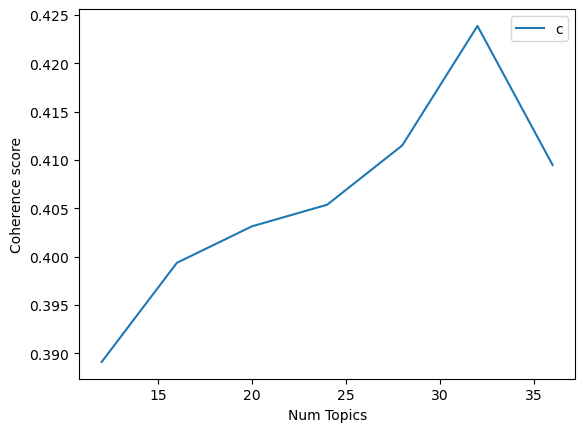

In [41]:
# Show graph
limit=40; start=12; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [63]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 12  has Coherence Value of 0.3891
Num Topics = 16  has Coherence Value of 0.3994
Num Topics = 20  has Coherence Value of 0.4031
Num Topics = 24  has Coherence Value of 0.4054
Num Topics = 28  has Coherence Value of 0.4115
Num Topics = 32  has Coherence Value of 0.4239
Num Topics = 36  has Coherence Value of 0.4095


In [46]:
#we can see that the best model is model with 32 topics
best_lda_model=model_list[-2]

In [59]:
best_model_topics=best_lda_model.show_topics(num_topics=32, num_words=10)

In [62]:
best_model_topics

[(0,
  '0.036*"\'money\'," + 0.030*"\'pay\'," + 0.026*"\'house\'," + 0.020*"\'dog\'," + 0.020*"\'live\'," + 0.019*"\'job\'," + 0.016*"\'car\'," + 0.016*"\'move\'," + 0.015*"\'place\'," + 0.014*"\'living\',"'),
 (1,
  '0.082*"\'year\'," + 0.051*"\'school\'," + 0.032*"\'life\'," + 0.029*"\'move\'," + 0.026*"\'college\'," + 0.023*"\'long\'," + 0.022*"\'live\'," + 0.021*"\'start\'," + 0.019*"\'country\'," + 0.018*"\'time\',"'),
 (2,
  '0.031*"\'issue\'," + 0.023*"\'feel\'," + 0.021*"\'partner\'," + 0.020*"\'mental\'," + 0.019*"\'need\'," + 0.019*"\'help\'," + 0.019*"\'anxiety\'," + 0.017*"\'health\'," + 0.017*"\'struggle\'," + 0.015*"\'lot\',"'),
 (3,
  '0.028*"\'meditation\'," + 0.023*"\'thought\'," + 0.021*"\'mind\'," + 0.016*"\'experience\'," + 0.016*"\'focus\'," + 0.014*"\'meditate\'," + 0.011*"\'body\'," + 0.009*"\'practice\'," + 0.008*"\'brain\'," + 0.008*"\'world\',"'),
 (4,
  '0.032*"\'look\'," + 0.020*"\'eye\'," + 0.016*"\'hand\'," + 0.013*"\'wear\'," + 0.011*"\'hair\'," + 0.010*"

topic 25 is clearly about abuse

### Conclusion:
* mallet model performs better than generic LDA model
* to a certain point, the larger the topics bumber is, the better the cohenrence scores are. But one should not choose the topic number base on the cohenrence score. 
* try diffrent numbers of topics and choose one that make sense for the use case.